# Mini-project 1: Deep Q-learning for Epidemic Mitigation

### Authors : Mohamed Hichem hadhri, Yassine Chaouch

necessary imports

In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

""" Seeding for reproducibility """
seed = 0
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

%matplotlib inline

In [2]:
def parse_logs(dyn, log):
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return total,cities,actions



def plot_info(total, cities, actions, action_plot=True):
    """ Plot the results """
    from matplotlib.ticker import MultipleLocator

    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    if action_plot:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    if action_plot:
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')


    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()


def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)


#### 1. Introduction

**Question 1.a)** study the behavior of the model when epidemics are unmitigated <br>

Run the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is taken, i.e. all values in the action dictionary are set to False) and produce three plots:




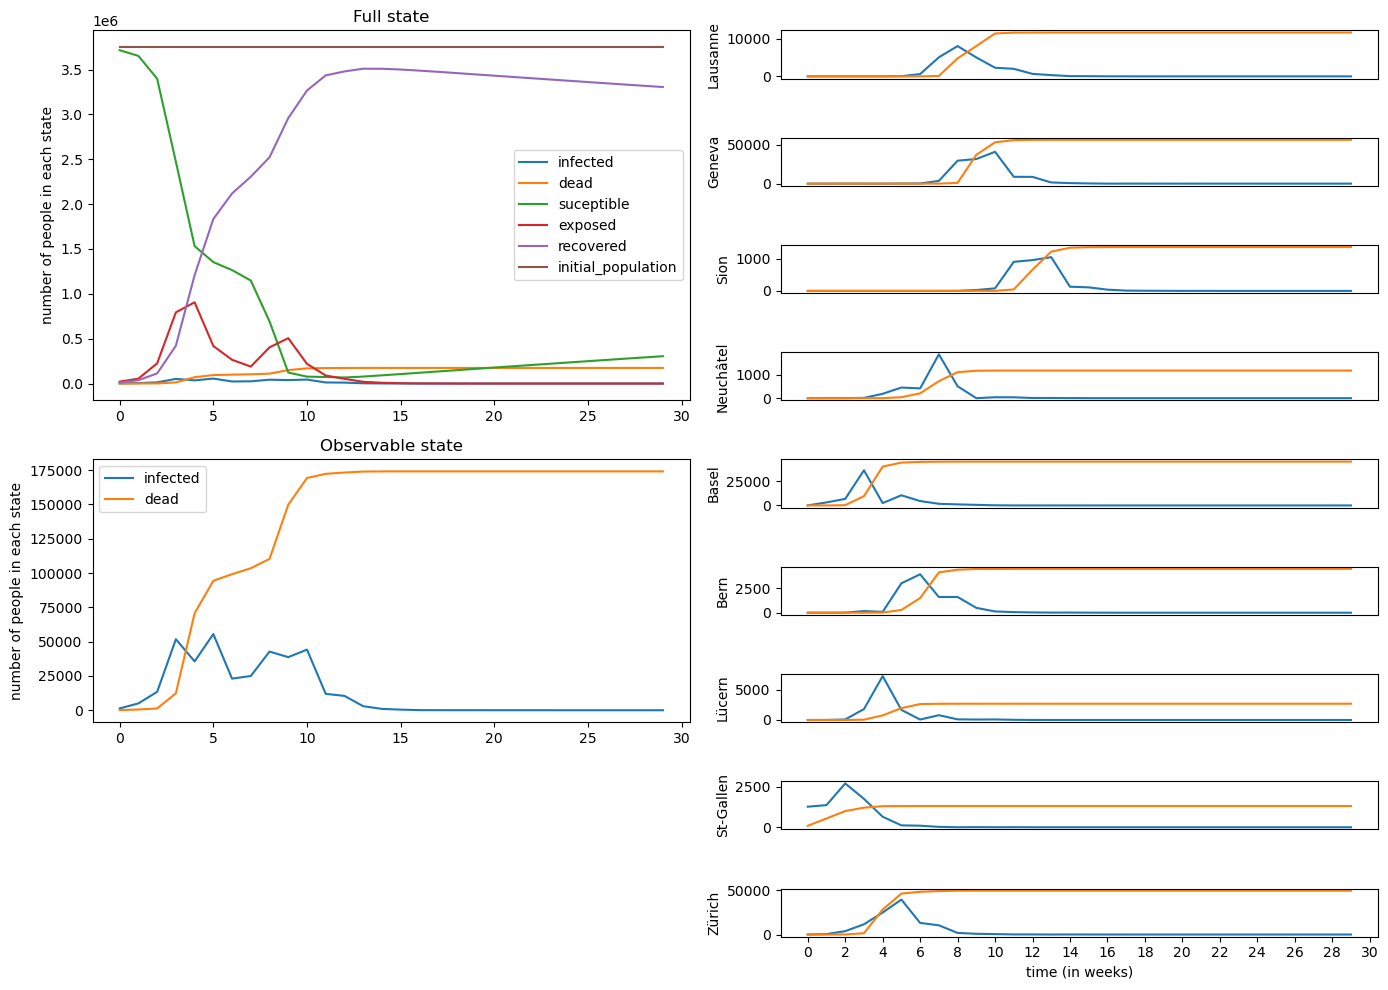

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# load the switzerland map
dyn = ModelDynamics('config/switzerland.yaml') 

# create environment
env = Env(dyn, action_space=None, observation_space=None) 

# DO NOTHING
action = { 
    'confinement': False, 
    'isolation': False, 
    'hospital': False, 
    'vaccinate': False,
}


""" Run the simulations, seeded"""
log = []
finished = False
obs, info = env.reset(seed)
for t in range(30):
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities,actions, action_plot=False)

From the results above, we can clearly see the rate of mortality is high, e.g the number of deaths increases explonentially at the first 15 weeks, and the it converges sloowly to amaximum. Moreover, the number of Infected people increases exponentially at first and then it stabilizes for some weeksm until it drops qucikly to zero. This can be xplained that infected people can turn to either dead or recovered and at the end all the population is either dead or recovered. <br>

Fron the results of each city, we can observe a trend. The number of infected people peaks around 4 to 6 weeks, followed by an increaed rate of mortality, This is due to the absence of actions to reduce the arete of spread and the rate of mortality like Isolation and hospitality <br>

#### 2. Professor Russo’s Policy

**Question 2.a)** Implement Pr. Russo’s Policy

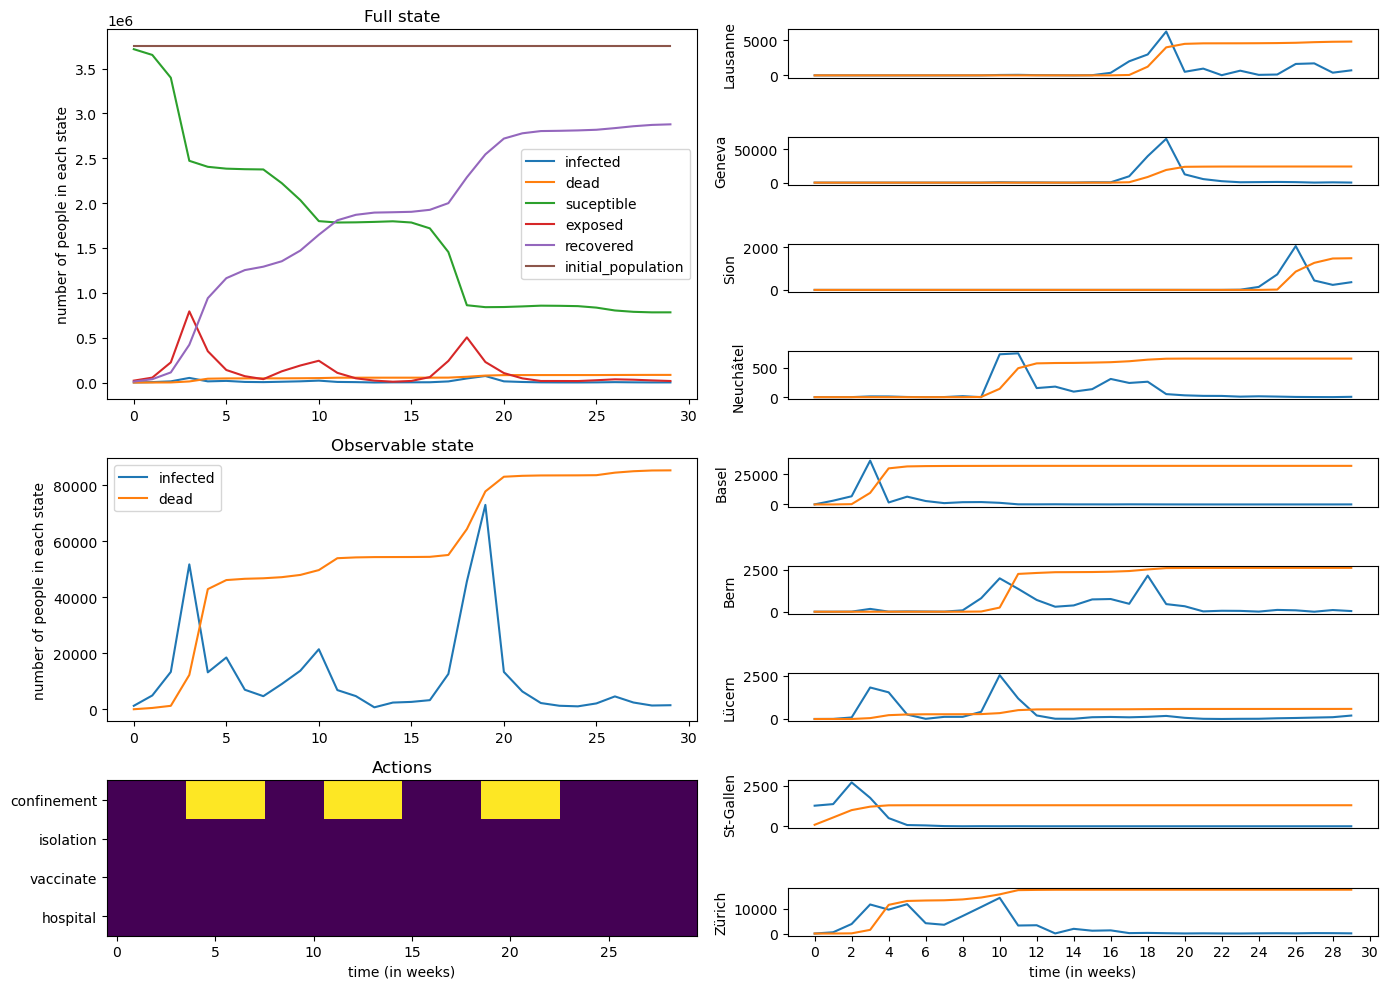

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from  Russo import Russo
from utils import Utils

dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map



env = Env(dyn, action_space=None, observation_space=None, action_preprocessor=Utils.action_preprocessor) 



agent = Russo(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed)
agent.reset()

while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) 
   
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

**Question 2.b)** Evaluate Pr. Russo’s Policy

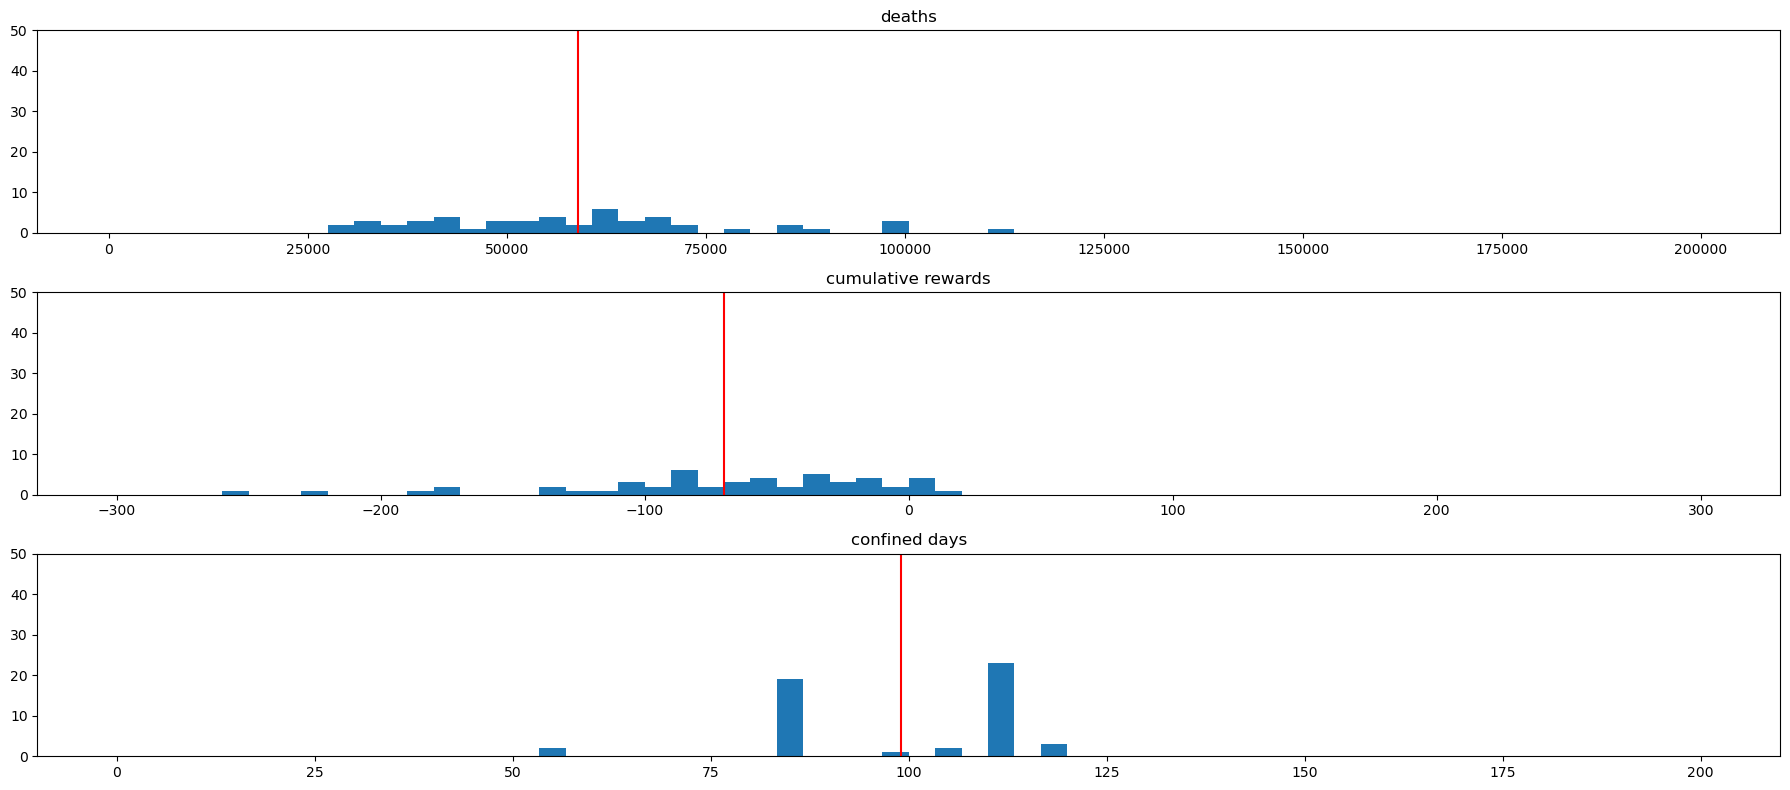

Average death number: 58922.9
Average number of confined days: 98.98
Average cumulative reward: -69.82


In [5]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map



env = Env(dyn, action_space=None, observation_space=None, action_preprocessor=Utils.action_preprocessor) # create environment

agent = Russo(env)

nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []

"""Run the simulations, seeded"""
for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)
   
    agent.reset()
    for t in range(30):
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
   
    total, cities, actions = parse_logs(dyn, log)

    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)

    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    

""" Plot """
fig, ax = plt.subplots(3,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')



##### 3 A Deep Q-learning approach

##### 3.1 Deep Q-Learning with a binary action space

**Question 3.a)** implementing Deep Q-Learning

In [6]:
import torch
import numpy as np
import random
from QLearning import QAgent
from utils import Utils

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

""" Seeding for reproducibility """
seed = 0
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

%matplotlib inline

BATCH_SIZE = 2048
GAMMA = 0.9
EPS = 0.7
LR = 5e-3

# seed the random number generator for reproductibility
random.seed(seed)

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space
action_space  =   spaces.Discrete(2)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor)

# Define the agent
agent = QAgent(env, device , 2* dyn.n_cities* dyn.env_step_length)
# Define the optimizer
optimizer = torch.optim.Adam(agent.policy_network.parameters(), lr=LR)

# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20

# Define the training and evaluation traces
train_trace = np.zeros(num_episodes)
eval_trace = np.zeros(num_episodes)

# Loop over the episodes
for episode in range(num_episodes):
    # Run an episode
    obs, info = env.reset()
    done = False
    cumulative_reward = 0
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
   
    while not done:
        action = agent.act(obs, eps=EPS)
        next_obs, R, done, info = env.step(action)
        R = torch.tensor(R, device=device)
        
        if done:
            next_obs = None
        else:
            next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)

      
       
        agent.remember(obs, action, next_obs,R )
        obs = next_obs
        cumulative_reward += int(R)
    
    # Log the cumulative reward to the training trace
    train_trace[episode] = int(cumulative_reward)
    
    # Run a traing step
    agent.optimize_model(optimizer,episode=episode)
   
   
    
    # Run an evaluation procedure every 50 episodes or on the last episode
    if episode % 50 == 0 or episode == num_episodes - 1:
        eval_cumulative_reward = 0
        for eval_episode in range(num_eval_episodes):
            obs, info = env.reset()
            done = False
            obs = torch.tensor(obs, dtype=torch.float32, device=device)
            while not done:
                action = agent.act(obs, eps=0.0)
                obs, R, done, info = env.step(action)
                eval_cumulative_reward += R
                obs = torch.tensor(obs, dtype=torch.float32, device=device)

        eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)
        
        # Log the evaluation results to the evaluation trace
        eval_trace[episode] = eval_average_reward
        
        print(f"Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")


/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/2859877405.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/2859877405.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R = torch.tensor(R, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/2859877405.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_obs = torch.tensor(next_obs, dtype=torch.float32, device=

Episode: 0, Train Reward: -130.00, Eval Reward: -132.00
Episode: 50, Train Reward: -69.00, Eval Reward: 14.00
Episode: 100, Train Reward: -5.00, Eval Reward: 21.00
Episode: 150, Train Reward: 5.00, Eval Reward: 25.00
Episode: 200, Train Reward: -225.00, Eval Reward: 23.00
Episode: 250, Train Reward: -170.00, Eval Reward: 28.00
Episode: 300, Train Reward: -100.00, Eval Reward: 18.00
Episode: 350, Train Reward: -44.00, Eval Reward: 30.00
Episode: 400, Train Reward: -120.00, Eval Reward: 24.00
Episode: 450, Train Reward: -229.00, Eval Reward: 23.00
Episode: 499, Train Reward: -99.00, Eval Reward: 28.00


/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/1830956041.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/1830956041.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


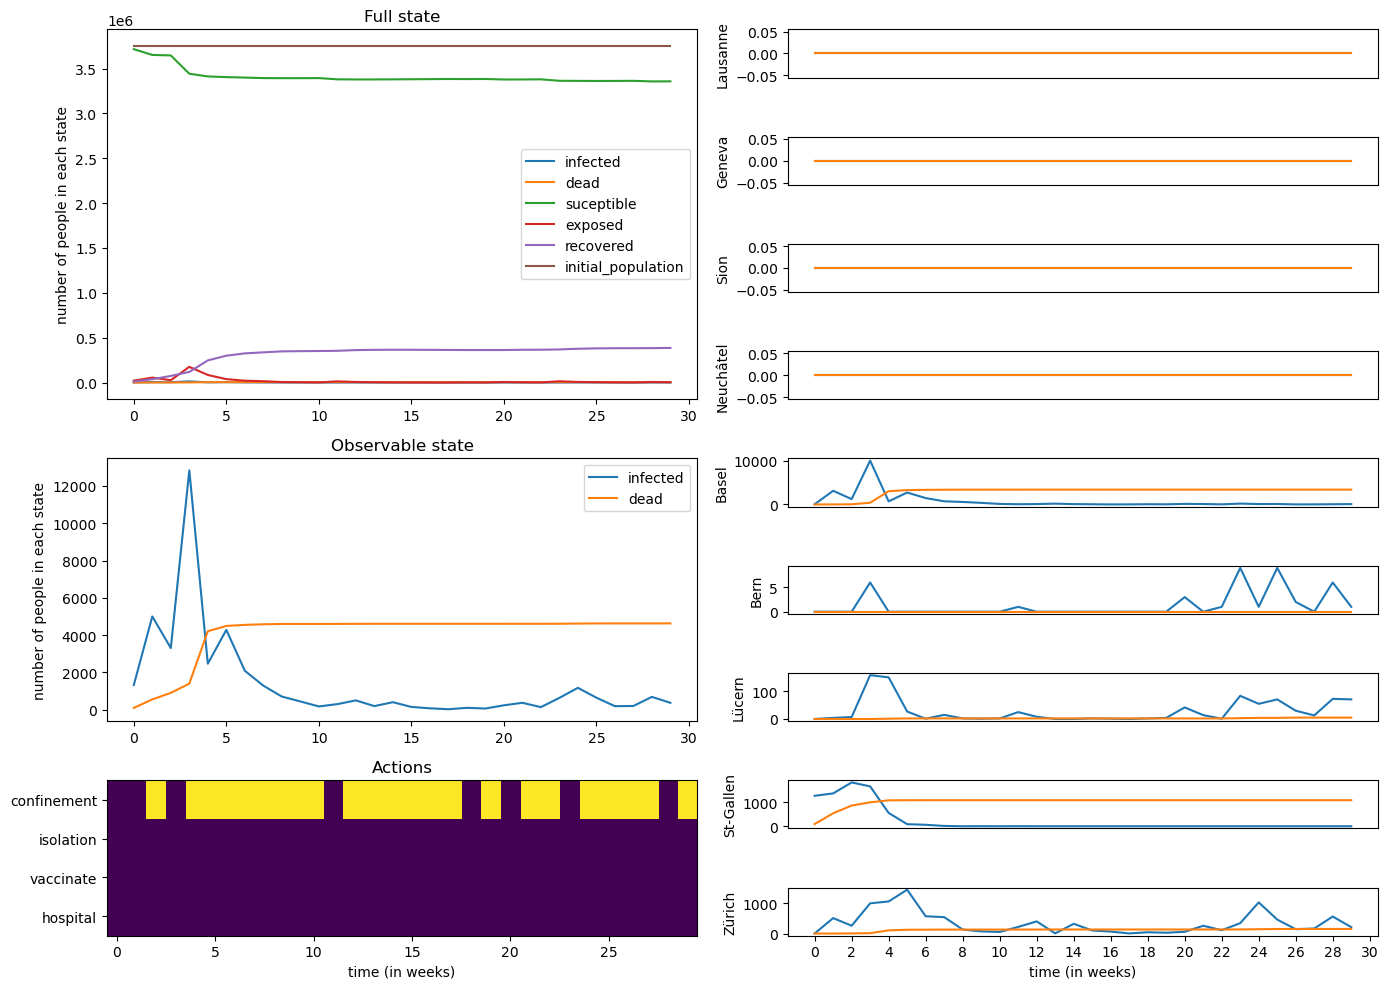

In [7]:


""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed)

while not finished:
       
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
       
    action = agent.act(obs, eps=0.0)
    obs, R, finished, info = env.step(action)
               
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
   
    log.append(info) # save the information dict for logging
  
    
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

In [8]:
import torch
import numpy as np
import random
from QLearning import QAgent
from utils import Utils

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

""" Seeding for reproducibility """
seed = 0
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

%matplotlib inline

BATCH_SIZE = 2048
GAMMA = 0.9
EPS = 0.7
LR = 5e-3

# seed the random number generator for reproductibility
random.seed(seed)

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space
action_space  =   spaces.Discrete(2)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor)

# Define the agent
agent = QAgent(env, device , 2* dyn.n_cities* dyn.env_step_length)
# Define the optimizer
optimizer = torch.optim.Adam(agent.policy_network.parameters(), lr=LR)

# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20


# Define the training and evaluation traces
train_trace = np.zeros(num_episodes)
eval_trace = np.zeros(num_episodes)



# Loop over the episodes
for episode in range(num_episodes):
    # Run an episode
    obs, info = env.reset(seed=seed)
    done = False
    cumulative_reward = 0
    obs = torch.tensor(obs, dtype=torch.float32, device=device)

    while not done:
        action = agent.act(obs, eps=EPS,eps_decay=True,episode=episode,num_episodes=num_episodes,eps_min=0.2)
        next_obs, R, done, info = env.step(action)
        R = torch.tensor(R, device=device)
        
        if done:
            next_obs = None
        else:
            next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)

    
    
        agent.remember(obs, action, next_obs,R )
        obs = next_obs
        cumulative_reward += int(R)
    
    # Log the cumulative reward to the training trace
    train_trace[episode] = int(cumulative_reward)
    
    # Run a traing step
    agent.optimize_model(optimizer,episode=episode)


    
    # Run an evaluation procedure every 50 episodes or on the last episode
    if episode % 50 == 0 or episode == num_episodes - 1:
        eval_cumulative_reward = 0
        for eval_episode in range(num_eval_episodes):
            obs, info = env.reset()
            done = False
            obs = torch.tensor(obs, dtype=torch.float32, device=device)
            while not done:
                action = agent.act(obs, eps=0.0)
                obs, R, done, info = env.step(action)
                eval_cumulative_reward += R
                obs = torch.tensor(obs, dtype=torch.float32, device=device)

        eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)
        
        # Log the evaluation results to the evaluation trace
        eval_trace[episode] = eval_average_reward
        
        print(f"Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")




/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/2175876153.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/2175876153.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R = torch.tensor(R, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/2175876153.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_obs = torch.tensor(next_obs, dtype=torch.float32, device=

Episode: 0, Train Reward: -170.00, Eval Reward: -161.00
Episode: 50, Train Reward: -83.00, Eval Reward: -53.00
Episode: 100, Train Reward: 12.00, Eval Reward: -19.00
Episode: 150, Train Reward: -124.00, Eval Reward: -6.00
Episode: 200, Train Reward: 17.00, Eval Reward: 6.00
Episode: 250, Train Reward: -111.00, Eval Reward: 14.00
Episode: 300, Train Reward: -33.00, Eval Reward: 8.00
Episode: 350, Train Reward: -141.00, Eval Reward: 1.00
Episode: 400, Train Reward: -263.00, Eval Reward: -11.00
Episode: 450, Train Reward: -125.00, Eval Reward: -10.00
Episode: 499, Train Reward: -219.00, Eval Reward: 22.00


Text(0, 0.5, 'Reward')

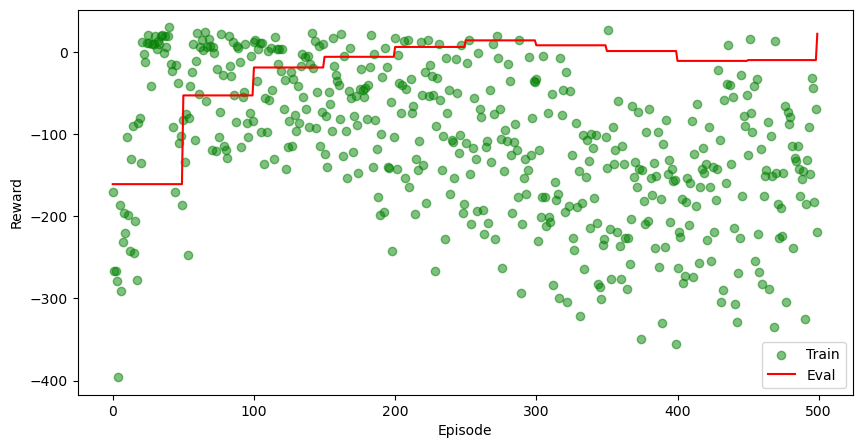

In [15]:

# replace zeros in the evaluation trace with the last non-zero value (we evaluate every 50 episodes)
for i in range(len(eval_trace)):
    if eval_trace[i] == 0:
        eval_trace[i] = eval_trace[i-1]
    

# plot the training and evaluation traces
plt.figure(figsize=(10,5))
# change opactiy to 0.5 for a more transparent plot
colors = ['green']

[plt.scatter(np.arange(num_episodes),train_trace,label='Train',color='green',alpha=0.5)]
plt.plot(np.arange(num_episodes),eval_trace,label='Eval',color='red')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')


/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/1830956041.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_52050/1830956041.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


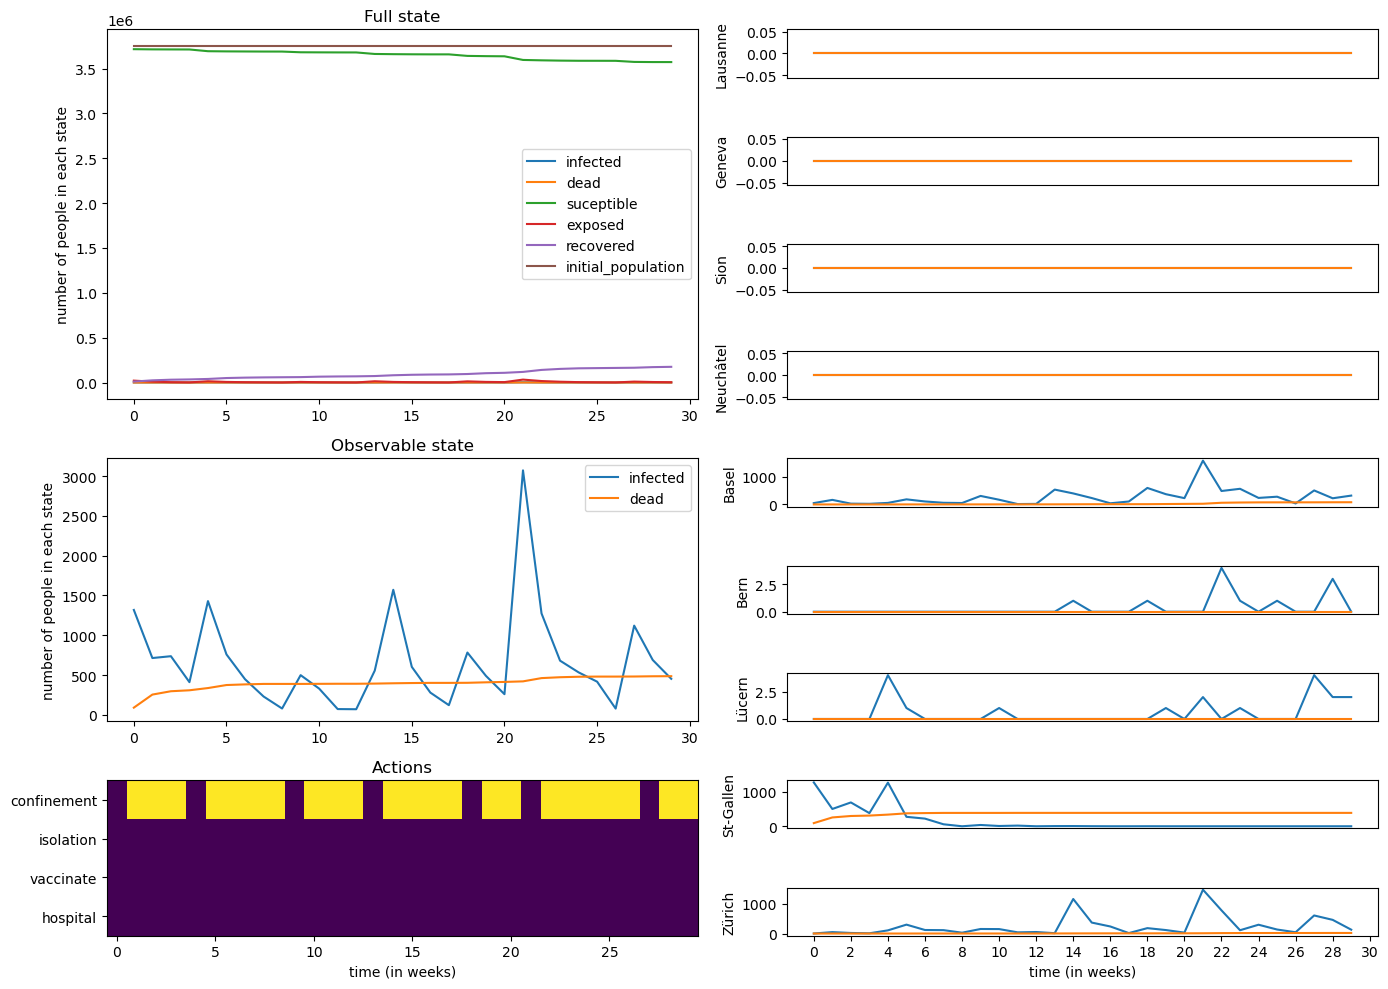

In [10]:


""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed)

while not finished:
       
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
       
    action = agent.act(obs, eps=0.0)
    obs, R, finished, info = env.step(action)
               
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
   
    log.append(info) # save the information dict for logging
  
    
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)